In [1]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


'\nDedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.\nThis script demonstrates solving a 2D Cartesian initial value problem. It can\nbe ran serially or in parallel, and uses the built-in analysis framework to save\ndata snapshots to HDF5 files. The `plot_snapshots.py` script can be used to\nproduce plots from the saved data. It should take about 5 cpu-minutes to run.\n\nFor incompressible hydro with two boundaries, we need two tau terms for each the\nvelocity and buoyancy. Here we choose to use a first-order formulation, putting\none tau term each on auxiliary first-order gradient variables and the others in\nthe PDE, and lifting them all to the first derivative basis. This formulation puts\na tau term in the divergence constraint, as required for this geometry.\n\nTo run and plot using e.g. 4 processes:\n    $ mpiexec -n 4 python3 rayleigh_benard.py\n    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5\n'

In [2]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

In [4]:
# Parameters
Lx, Lz = 40,1
Nx, Nz = 1280, 32
Ra_M = 4.5e5
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
f=0.05

Prandtl = 0.7
dealias = 3/2
stop_sim_time = 500
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [5]:
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

In [6]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
uy = dist.Field(name='uy', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)
Td=Lz**2/(nu*kappa)**(1/2)
Tc=(Lz/(M_0-M_H))**(1/2)
Tr=1/f
R_0=Tr/Tc
print('R_0',R_0)


x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])

ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

ux2=ux*ux
uy2=uy*uy
uz2=uz*uz

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_uy = d3.grad(uy) + ez*lift(tau_u3)# First-order reduction 
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction


kappa 0.001781741612749496
nu 0.0012472191289246471
R_0 20.0


In [7]:
# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, D, u, uy, tau_p, tau_M1, tau_M2, tau_D1, tau_D2, tau_u1, tau_u2, tau_u3, tau_u4], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) = - u@grad(M)")
problem.add_equation("dt(D) - kappa*div(grad_D) + lift(tau_D2) = - u@grad(D)")
problem.add_equation("dt(ux) + dx(p) - nu*div(grad_ux) + lift(tau_u2)@ex = - u@grad(ux)+f*uy")
problem.add_equation("dt(uz) + dz(p) - nu*div(grad_uz) + lift(tau_u2)@ez = - u@grad(uz) + B_op")
problem.add_equation("dt(uy) -nu*div(grad_uy) + lift(tau_u4)= -f*ux - u@grad(uy)")
problem.add_equation("uy(z=0) = 0")
problem.add_equation("dz(uy)(z=Lz) = 0")
problem.add_equation("u(z=0) = 0")
problem.add_equation("uz(z=Lz) = 0")
problem.add_equation("dz(ux)(z=Lz)=0")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("D(z=0) = D_0")
problem.add_equation("M(z=Lz) = M_H")
problem.add_equation("D(z=Lz) = D_H")
problem.add_equation("integ(p) = 0") # Pressure gauge


{'LHS': Integrate(Integrate(<Field 5366576976>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 5366576976>)),
 'F': <Field 5366268368>,
 'domain': <dedalus.core.domain.Domain at 0x13fe32b90>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [8]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


2023-10-20 09:16:44,499 subsystems 0/1 INFO :: Building subproblem matrices 1/640 (~0%) Elapsed: 0s, Remaining: 1m 08s, Rate: 9.4e+00/s
2023-10-20 09:16:48,425 subsystems 0/1 INFO :: Building subproblem matrices 64/640 (~10%) Elapsed: 4s, Remaining: 36s, Rate: 1.6e+01/s
2023-10-20 09:16:52,401 subsystems 0/1 INFO :: Building subproblem matrices 128/640 (~20%) Elapsed: 8s, Remaining: 32s, Rate: 1.6e+01/s
2023-10-20 09:16:54,441 subsystems 0/1 INFO :: Building subproblem matrices 161/640 (~25%) Elapsed: 10s, Remaining: 30s, Rate: 1.6e+01/s
2023-10-20 09:16:56,397 subsystems 0/1 INFO :: Building subproblem matrices 192/640 (~30%) Elapsed: 12s, Remaining: 28s, Rate: 1.6e+01/s
2023-10-20 09:17:00,359 subsystems 0/1 INFO :: Building subproblem matrices 256/640 (~40%) Elapsed: 16s, Remaining: 24s, Rate: 1.6e+01/s
2023-10-20 09:17:04,278 subsystems 0/1 INFO :: Building subproblem matrices 320/640 (~50%) Elapsed: 20s, Remaining: 20s, Rate: 1.6e+01/s
2023-10-20 09:17:04,398 subsystems 0/1 INFO :

In [9]:
# Initial condition
D.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
D['g'] *= z * (Lz - z) # Damp noise at walls
D['g'] += (D_H-D_0)*z # Add linear background
M.fill_random('g', seed=28, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += (M_H-M_0)*z # Add linear background

In [10]:
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_tasks(solver.state,layout='g')

In [11]:
# CFL
CFL = d3.CFL(solver, initial_dt=0.1, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.1, min_change=0, max_dt=max_timestep)
CFL.add_velocity(u)

In [12]:
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


In [13]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-10-20 09:17:23,335 __main__ 0/1 INFO :: Starting main loop
2023-10-20 09:17:30,611 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-01, dt=1.000000e-01, max(Re)=0.000000
2023-10-20 09:17:32,208 __main__ 0/1 INFO :: Iteration=11, Time=1.100000e+00, dt=1.000000e-01, max(Re)=0.086564
2023-10-20 09:17:34,391 __main__ 0/1 INFO :: Iteration=21, Time=2.200000e+00, dt=1.100000e-01, max(Re)=0.177000
2023-10-20 09:17:36,520 __main__ 0/1 INFO :: Iteration=31, Time=3.410000e+00, dt=1.210000e-01, max(Re)=0.341345
2023-10-20 09:17:38,061 __main__ 0/1 INFO :: Iteration=41, Time=4.620000e+00, dt=1.210000e-01, max(Re)=0.689378
2023-10-20 09:17:39,637 __main__ 0/1 INFO :: Iteration=51, Time=5.830000e+00, dt=1.210000e-01, max(Re)=1.427630
2023-10-20 09:17:41,208 __main__ 0/1 INFO :: Iteration=61, Time=7.040000e+00, dt=1.210000e-01, max(Re)=3.020318
2023-10-20 09:17:42,765 __main__ 0/1 INFO :: Iteration=71, Time=8.250000e+00, dt=1.210000e-01, max(Re)=6.426170
2023-10-20 09:17:44,316 __main__ 0/1 INFO

In [23]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5', 'snapshots/snapshots_s5.h5', 'snapshots/snapshots_s6.h5', 'snapshots/snapshots_s7.h5', 'snapshots/snapshots_s8.h5', 'snapshots/snapshots_s9.h5', 'snapshots/snapshots_s10.h5', 'snapshots/snapshots_s11.h5', 'snapshots/snapshots_s12.h5', 'snapshots/snapshots_s13.h5', 'snapshots/snapshots_s14.h5', 'snapshots/snapshots_s15.h5', 'snapshots/snapshots_s16.h5', 'snapshots/snapshots_s17.h5', 'snapshots/snapshots_s18.h5', 'snapshots/snapshots_s19.h5', 'snapshots/snapshots_s20.h5', 'snapshots/snapshots_s21.h5', 'snapshots/snapshots_s22.h5', 'snapshots/snapshots_s23.h5', 'snapshots/snapshots_s24.h5', 'snapshots/snapshots_s25.h5', 'snapshots/snapshots_s26.h5', 'snapshots/snapshots_s27.h5', 'snapshots/snapshots_s28.h5', 'snapshots/snapshots_s29.h5', 'snapshots/snapshots_s30.h5', 'snapshots/snapshots_s31.h5', 'snapshots/snapshots_s32.h5', 'snapshots/snapshots_s33.h5', 'snapshots/snapsho

In [15]:
n = 0
if not os.path.exists('rotational_uy'):
    os.mkdir('rotational_uy')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        uuyy = file['tasks']['uy']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            uuuyyy = np.transpose(uuyy[t, :, :])
            plt.contourf(uuuyyy, cmap='RdBu_r')
            plt.colorbar(label='uy component')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'rotational_uy/rot_uy_{"%04d" % n}.png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

2023-10-19 08:33:37,935 matplotlib.animation 0/1 WARNING :: MovieWriter ffmpeg unavailable; using Pillow instead.
2023-10-19 08:33:37,937 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


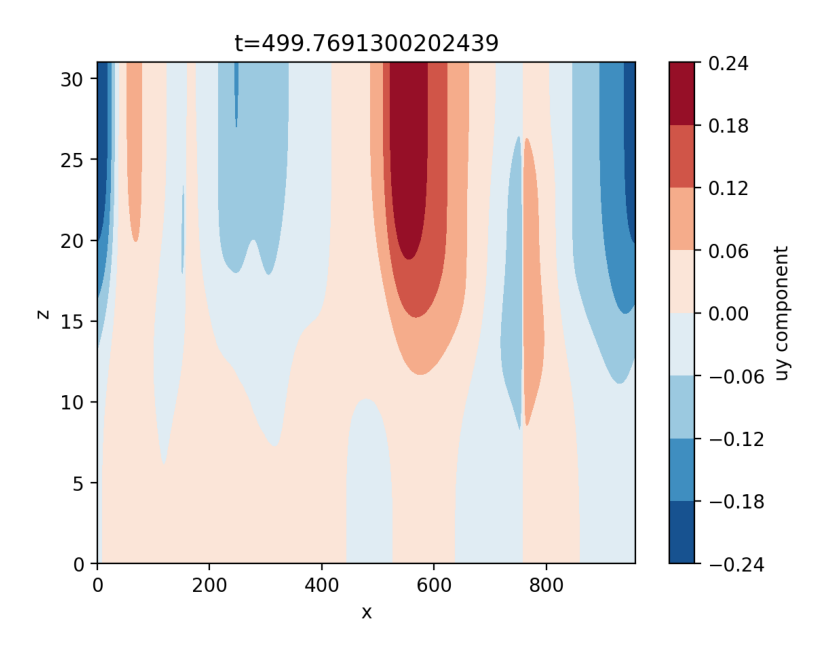

In [15]:
import matplotlib.animation as Animation
from PIL import Image
folder_dir = f'rotational_uy'
# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if
              os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()
# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]
fig = plt.figure(figsize=(16, 4), dpi=200)
fig.patch.set_visible(False)
plt.axis('off')
# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save(f'rotational_uy_component.gif', dpi=200)

KeyboardInterrupt: 

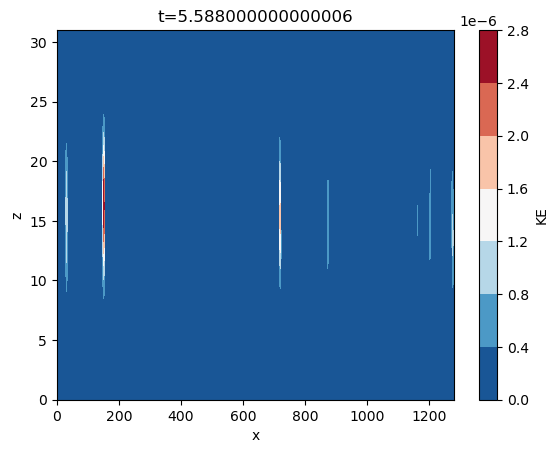

In [19]:
"""
KE GRAPHS
"""
n = 0
if not os.path.exists('KEs'):
    os.mkdir('KEs')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        uuyy = file['tasks']['uy']
        uuxz = file['tasks']['u']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            uuuyyy = np.transpose(uuyy[t, :, :])
            uuxz_trans = np.transpose(uuxz[t, :, :])
            uxxuzz = np.ndarray.tolist(uuxz_trans)
            for lay_1 in range(len(uuxz_trans)):
                for lay_2 in range(len(uuxz_trans[lay_1])):
                    modulus = np.linalg.norm(uuxz_trans[lay_1][lay_2])
                    uxxuzz[lay_1][lay_2] = modulus
            to_plot = np.square(uuuyyy)+np.square(uxxuzz)
            plt.contourf(to_plot, cmap='RdBu_r')
            plt.colorbar(label='KE')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'KEs/KE_{"%04d" % n}.png', dpi=100, bbox_inches='tight')
            matplotlib.pyplot.close()

In [21]:
"""
TOTAL KE
"""
n = 0
if not os.path.exists('TOT_KEs'):
    os.mkdir('TOT_KEs')

all_tot_ke = []

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        uuyy = file['tasks']['uy']
        uuxz = file['tasks']['u']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            uuuyyy = np.transpose(uuyy[t, :, :])
            uuxz_trans = np.transpose(uuxz[t, :, :])
            uxxuzz = np.ndarray.tolist(uuxz_trans)
            for lay_1 in range(len(uuxz_trans)):
                for lay_2 in range(len(uuxz_trans[lay_1])):
                    modulus = np.linalg.norm(uuxz_trans[lay_1][lay_2])
                    uxxuzz[lay_1][lay_2] = modulus
            to_plot = np.square(uuuyyy)+np.square(uxxuzz)
            all_tot_ke.append(np.sum(to_plot))
            n = n + 1
print(all_tot_ke)




[0.0, 3.359706871644927e-06, 5.6623475613501745e-06, 9.317555246552936e-06, 1.3364747073146131e-05, 1.669174706239361e-05, 2.0427044123108405e-05, 2.468522678358052e-05, 3.239731698343931e-05, 3.9096453071843226e-05, 4.770347551941551e-05, 5.845913016481547e-05, 7.205552136355983e-05, 8.941885802996697e-05, 0.00011179479585390575, 0.00014085176269223166, 0.00017882362463016773, 0.00022869399156001473, 0.0003348859647436208, 0.0004350158931598504, 0.0005679598829977639, 0.00074482359849533, 0.0009805327096989057, 0.0012951714661703618, 0.001715771574516683, 0.002278728173614876, 0.003033049861546122, 0.004044728728356662, 0.005402539351275961, 0.007225944341322465, 0.009676078475951339, 0.01297037563386903, 0.01740239735946719, 0.023368680383927205, 0.036416826477626875, 0.04899301771017485, 0.0659559794152568, 0.08884797174512529, 0.11975731786810487, 0.16151285057392192, 0.21794874873871345, 0.2942639112757246, 0.3975116118011298, 0.5372677763696905, 0.7265405155317439, 0.983017267844

2000
2000


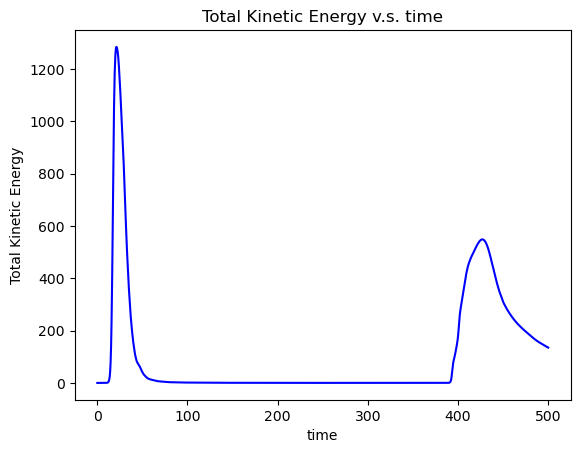

In [22]:
print(len(all_tot_ke))
figure_x_axis = np.array([x/4 for x in range(1, len(all_tot_ke)+1)])
print(len(figure_x_axis))
plt.plot(figure_x_axis, all_tot_ke, color = 'blue')
plt.xlabel('time')
plt.ylabel('Total Kinetic Energy')
plt.title('Total Kinetic Energy v.s. time')
plt.show()

In [24]:
n = 0
if not os.path.exists('rotational'):
    os.mkdir('rotational')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        drybuoyancy = file['tasks']['D']
        buoyancy = np.maximum(moistbuoyancy, drybuoyancy - N_s2 * z)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            mb = np.transpose(moistbuoyancy[t, :, :])
            db = np.transpose(drybuoyancy[t, :, :])
            bu = np.transpose(buoyancy[t, :, :])
            plt.contourf(bu, cmap='RdBu_r')
            plt.colorbar(label='buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'rotational/rot_ {"%04d" % n} .png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

2023-10-20 11:09:33,815 matplotlib.animation 0/1 WARNING :: MovieWriter ffmpeg unavailable; using Pillow instead.
2023-10-20 11:09:33,819 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


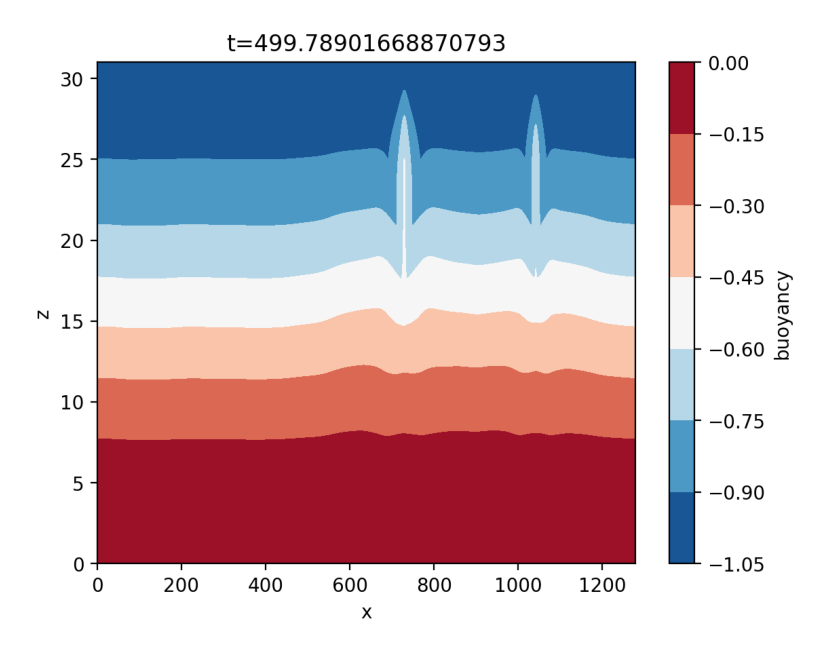

In [25]:
import matplotlib.animation as Animation
from PIL import Image
folder_dir = f'rotational'
# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if
              os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()
# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]
fig = plt.figure(figsize=(16, 4), dpi=200)
fig.patch.set_visible(False)
plt.axis('off')
# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save(f'rotational.gif', dpi=200)

In [ ]:
n = 0
if not os.path.exists('moist buoyancy'):
    os.mkdir('moist buoyancy')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            mb = np.transpose(moistbuoyancy[t, :, :])
            plt.contourf(mb, cmap='RdBu_r')
            plt.colorbar(label='moist buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'moist buoyancy/mb_ {"%04d" % n} .png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

2023-09-27 20:08:24,578 matplotlib.animation 0/1 WARNING :: MovieWriter ffmpeg unavailable; using Pillow instead.
2023-09-27 20:08:24,580 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


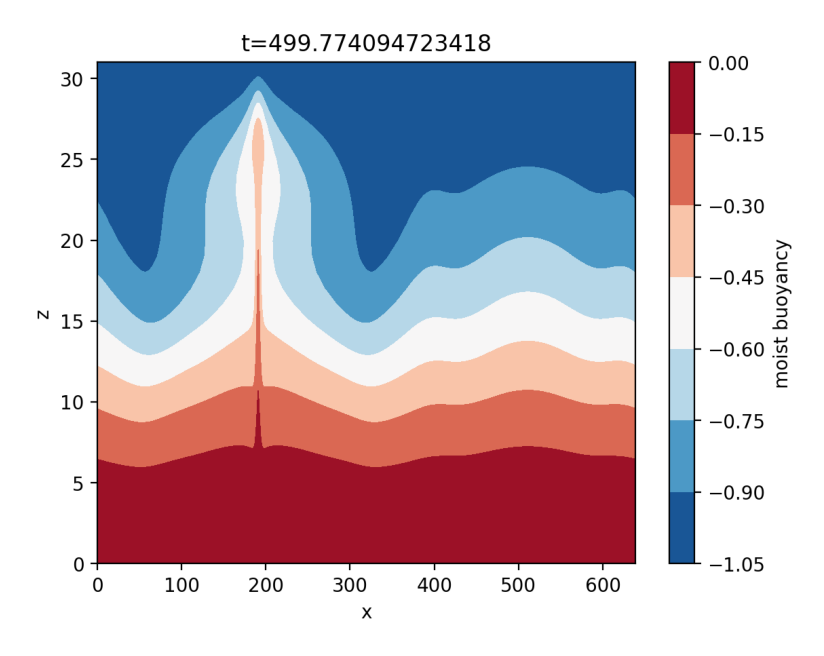

In [ ]:
import matplotlib.animation as Animation
from PIL import Image
folder_dir = f'moist buoyancy'
# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if
              os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()
# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]
fig = plt.figure(figsize=(16, 4), dpi=200)
fig.patch.set_visible(False)
plt.axis('off')
# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save(f'moist buoyancy.gif', dpi=200)